In [1]:
%%time
import os
import subprocess
import numpy as np
import pandas as pd
import scipy.io.wavfile
from sys import getsizeof
from scipy import signal
from IPython.display import Audio
import csv
import matplotlib.pyplot as plt
import seaborn as sns

# feature extraction with pyAudioAnalysis:
from pyAudioAnalysis import ShortTermFeatures

import cudf
import cuspatial
import cupy as cp
import cusignal

print(cuspatial.point_in_polygon_bitmap)
print(cudf.__version__)

import warnings
warnings.filterwarnings('ignore')

<function point_in_polygon_bitmap at 0x7f2a743a40d0>
0.13.0
CPU times: user 4.42 s, sys: 436 ms, total: 4.86 s
Wall time: 4.88 s


In [2]:
%%time
test_file = './test/example.wav'
# test_file = '../data/701_282_5.4_23719.wav'

resampled_file = './test/resampled.wav'

sr, wave = scipy.io.wavfile.read(test_file) 
# Note that this particular file has a single channel. Most audio files will have two (stereo) channels.

print('Data:', wave)
print('Sampling rate:', sr)
print('Samples:', len(wave))
print('Audio length:', round(wave.size/sr, 4), 'seconds')
print('Lowest amplitude:', min(wave))
print('Highest amplitude:', max(wave))

Audio(test_file)

Data: [-1691 -1640 -1620 ...   583   649   645]
Sampling rate: 44100
Samples: 199655
Audio length: 4.5273 seconds
Lowest amplitude: -5381
Highest amplitude: 5056
CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 101 ms


In [3]:
# Let's fix target parameters:
target_length = 5 # seconds
target_sr = 48000 # sampling rate, samples per second

In [4]:
%%time
# Now resample to target_sr * target_length
# and scale amplitude
wave_gpu = cp.asarray(wave)
resampled_wave_gpu = cusignal.resample(wave_gpu, target_sr*target_length)
resampled_wave = cp.asnumpy(resampled_wave_gpu).astype(int)

# resampled_wave_cpu = scipy.signal.resample(wave, int(target_sr*target_length))
# resampled_wave = resampled_wave_cpu.astype(int)

scaled_wave = np.int16(resampled_wave/np.max(np.abs(resampled_wave)) * 32767)

CPU times: user 348 ms, sys: 51.6 ms, total: 400 ms
Wall time: 398 ms


In [5]:
scipy.io.wavfile.write(resampled_file, target_sr, scaled_wave)
os.chown(resampled_file, 1000, 1000)
print('Data:', scaled_wave)
print('Sampling rate:', target_sr)
print('Samples:', len(scaled_wave))
print('Audio length:', round(scaled_wave.size/target_sr, 4), 'seconds')
print('Lowest amplitude:', min(scaled_wave))
print('Highest amplitude:', max(scaled_wave))

Audio(resampled_file)

Data: [-10287 -10798  -8985 ...   2719   5475   1934]
Sampling rate: 48000
Samples: 240000
Audio length: 5.0 seconds
Lowest amplitude: -32767
Highest amplitude: 30789


In [6]:
#### ------------------------------------------------------------
####  wav -> resample -> features -> drop_unwanted -> to_pandas
#### ------------------------------------------------------------
### define procedure to generate features from input_file including resampling, 
def wav_to_features(input_file):
    sr, wave = scipy.io.wavfile.read(input_file)

    # some wav files can be corrupted, e.g. without any samples with file size 
    # ~0 bytes - 100 bytes which seems to contain only headers but no data
    if len(wave) == 0:
        print(f"\n[Bad file] {input_file}")
        os.remove(input_file)
        return None
    # Let's fix target parameters:
    target_length = 5 # seconds
    target_sr = 48000 # sampling rate, samples per second
    
    # resample on CPU/GPU
    try:
        wave_gpu = cp.asarray(wave)
        resampled_wave_gpu = cusignal.resample(wave_gpu, target_sr*target_length)
        resampled_wave = cp.asnumpy(resampled_wave_gpu).astype(int)
        # resampled_wave_cpu = scipy.signal.resample(wave, int(target_sr*target_length))
        # resampled_wave = resampled_wave_cpu.astype(int)
        scaled_wave = np.int16(resampled_wave/np.max(np.abs(resampled_wave)) * 32767)
    except:
        scipy.io.wavfile.write("./tmp.wav", sr, wave)
        os.chown("./tmp.wav", 1000, 1000)
        print('File:', input_file)
        print('Data:', wave)
        print('Sampling rate:', target_sr)
        print('Original samples:', len(wave))
        print('Original audio length:', round(wave.size/sr, 4), 'seconds')
        print('Lowest amplitude:', min(wave))
        print('Highest amplitude:', max(wave))
        print('Read retries:', read_retry)
        Audio("./tmp.wav")
        raise SystemExit("Stopping further execution on error.")

    # take short-term features:
    features, feature_names = ShortTermFeatures.feature_extraction(scaled_wave, sr, len(scaled_wave), len(scaled_wave))
    # save scaled wav to file 
    tmp_wav = "./tmp.wav"
    scipy.io.wavfile.write(tmp_wav, target_sr, scaled_wave)
    os.chown(resampled_file, 1000, 1000)
    # and collect sox statistics:
    sox = subprocess.getoutput(f"sox {tmp_wav} -n stats 2>&1")
    os.remove(tmp_wav)

    # parse sox stats:
    sox = sox.split("\n")
    for i, j in enumerate(sox):
        sox[i] = list(filter(None, j.split("  ")))
        sox[i][0] = f"sox_{sox[i][0].strip().lower().replace(' ', '_')}"
        sox[i][1] = sox[i][1].strip()
        try:
            sox[i][1] = float(sox[i][1])
        except ValueError:
            None
    # put all features to dataframe
    data = pd.DataFrame(data=[features.flatten()], columns=feature_names)
    for j in sox:
        data[f"{j[0]}"] = j[1]
    # add filename
    data["filename"] = os.path.basename(input_file)
    # Now there is a need to remove useles features - static and string
    # Based on
    # 1_wav_to_features.ipynb
    # and 
    # 2_features_to_dataset.ipynb
    # need to keep only these features:
    features = ['energy',
                 'energy_entropy',
                 'filename',
                 'mfcc_1',
                 'mfcc_10',
                 'mfcc_11',
                 'mfcc_12',
                 'mfcc_13',
                 'mfcc_2',
                 'mfcc_3',
                 'mfcc_4',
                 'mfcc_5',
                 'mfcc_6',
                 'mfcc_7',
                 'mfcc_8',
                 'mfcc_9',
                 'sox_rms_lev_db',
                 'sox_rms_pk_db',
                 'spectral_centroid',
                 'spectral_entropy',
                 'spectral_rolloff',
                 'spectral_spread',
                 'zcr'
               ]
    data.drop(data.columns.difference(features), 1, inplace=True)
    return data

In [7]:
%%time
test_dataframe = wav_to_features(test_file)

CPU times: user 542 ms, sys: 93.4 ms, total: 635 ms
Wall time: 217 ms


In [8]:
%%time 
source_dir = "../data/sliced/"
source_files = []
data = pd.DataFrame(data=[], columns=test_dataframe.columns)

# sort all files
for j in sorted(os.listdir(source_dir)):
    source_files += [f"{source_dir}{j}"]
print(f"{len(source_files)} files sorted, computing features")
print()

# need to handle memory management manually
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

# generate featupes per each file and put to dataframe
for idx, j in enumerate(source_files):
    file_features = wav_to_features(j)
    if file_features is not None:
        data = data.append(file_features, ignore_index=True)
    if idx % 5 == 0:
        # nice feature, printing on the same line :)
        print(f"\r[{idx}/{len(source_files)}] {round(100.0 * idx/len(source_files), 2)}%: {j}", end = "")
        # You can clear the memory pool by calling `free_all_blocks`.
        mempool.free_all_blocks()
        pinned_mempool.free_all_blocks()

78581 files sorted, computing features

[78580/78581] 100.0%: ../data/sliced/9_96_5.04_8855.wavCPU times: user 12h 37min 33s, sys: 1h 53min 13s, total: 14h 30min 46s
Wall time: 3h 48min 16s


In [14]:
import shutil   

# drop <inf> rows
data.drop(data[data["sox_rms_lev_db"] == float("-inf")].index, inplace=True)

# save features to csv
data.to_csv("../data/dataset/features.csv", index=False)
os.chown("../data/dataset/features.csv", 1000, 1000)

# remove previous results
if os.path.exists("../data/dataset/wav/") and os.path.isdir("../data/dataset/wav/"):
    shutil.rmtree("../data/dataset/wav/")

# recreate destination dir 
os.makedirs("../data/dataset/wav/")
os.chown("../data/dataset/wav/", 1000, 1000)

# move all dataset files to wav dir:
src_files = os.listdir(source_dir)
for file_name in src_files:
    full_file_name = os.path.join(source_dir, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, "../data/dataset/wav")

In [15]:
data.head(5)

,energy,energy_entropy,filename,mfcc_1,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_2,mfcc_3,...,mfcc_7,mfcc_8,mfcc_9,sox_rms_lev_db,sox_rms_pk_db,spectral_centroid,spectral_entropy,spectral_rolloff,spectral_spread,zcr
0,0.001353,0.363362,0_0_5.4_47189.wav,-20.353333,0.389181,-0.474503,0.077828,0.354320,1.132189,-0.841119,...,-0.049869,0.012231,-0.241297,-28.65,-12.16,0.288751,0.584234,0.075542,0.322937,0.183709
1,0.020259,2.843993,0_102_4.76_41357.wav,-17.936578,0.242304,0.112681,0.112051,0.071367,2.228626,0.233894,...,0.049546,0.152943,0.109004,-16.93,-7.00,0.135859,0.219738,0.016375,0.166813,0.052367
2,0.019132,3.025625,0_108_4.6_39777.wav,-17.522664,0.085699,0.134672,0.079899,0.139727,1.930652,0.139545,...,0.071676,0.046929,-0.165693,-17.18,-8.88,0.123114,0.242308,0.024917,0.154889,0.039771
3,0.018992,3.046030,0_114_5.28_19659.wav,-16.903828,0.142301,0.086550,0.129850,-0.050196,1.618842,0.393879,...,0.052362,0.097397,-0.053896,-17.21,-8.56,0.112525,0.342611,0.030208,0.122113,0.049692
4,0.023728,3.055223,0_120_5.32_8841.wav,-25.266195,0.775490,-0.403941,-0.484175,0.485577,9.666652,-0.101120,...,-0.326503,-0.992077,0.473983,-16.25,-8.19,0.045948,0.107828,0.010600,0.055491,0.024542


In [16]:
# reindex columns to alphabetical order
data = data.reindex(sorted(data.columns), axis=1)
column_names = list(data.columns)
column_names

['energy',
 'energy_entropy',
 'filename',
 'mfcc_1',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_13',
 'mfcc_2',
 'mfcc_3',
 'mfcc_4',
 'mfcc_5',
 'mfcc_6',
 'mfcc_7',
 'mfcc_8',
 'mfcc_9',
 'sox_rms_lev_db',
 'sox_rms_pk_db',
 'spectral_centroid',
 'spectral_entropy',
 'spectral_rolloff',
 'spectral_spread',
 'zcr']

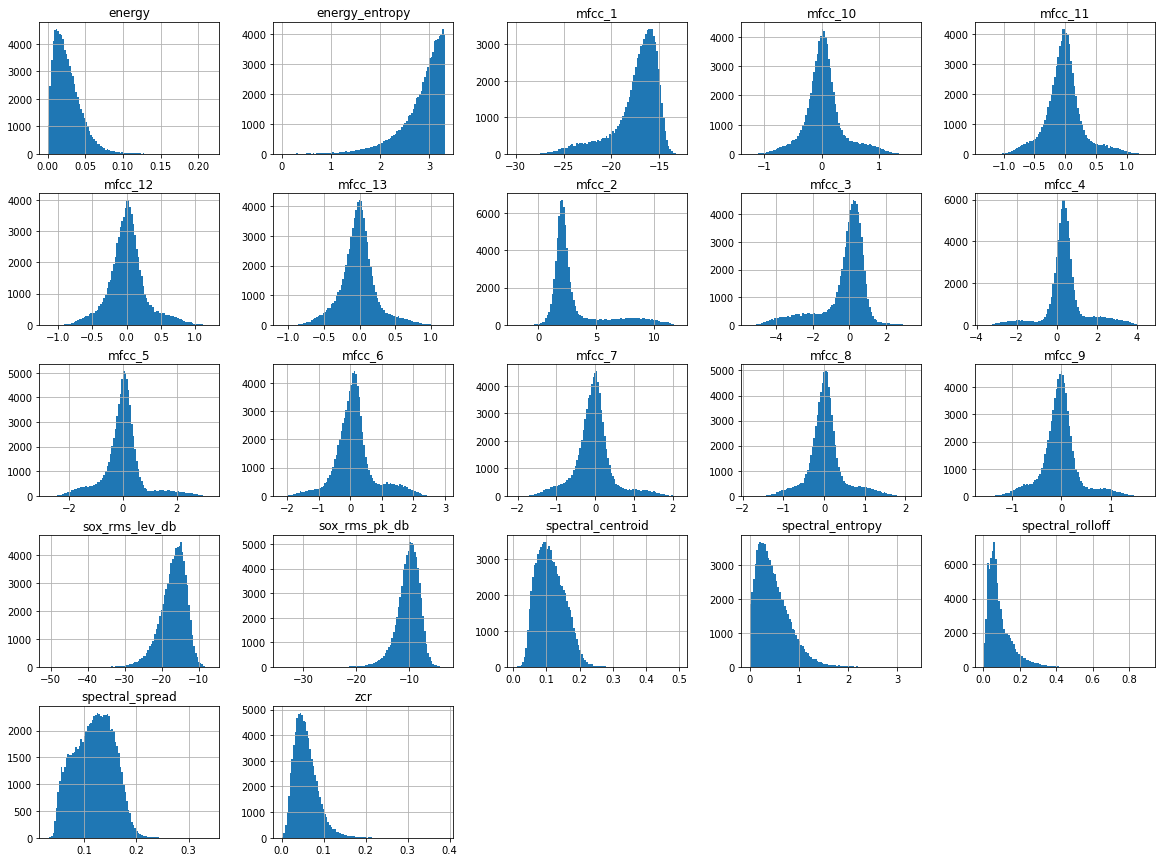

In [21]:
# value distributions
data.drop(["filename"], 1).hist(figsize=(20,15), bins=100);

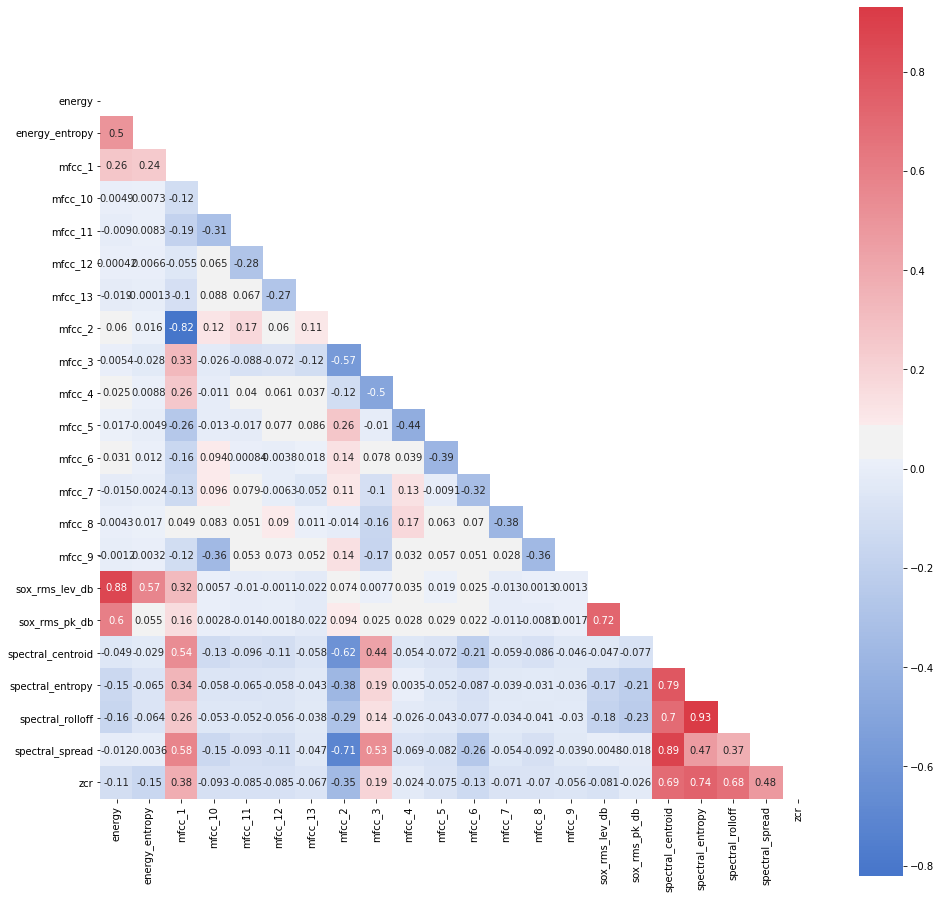

In [18]:
plt.figure(figsize = (16,16))
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(255, 10, as_cmap = True)
sns.heatmap(\
            data.corr(), \
            annot = True, \
            square = True, \
            mask = mask, \
            cmap = cmap \
).get_figure();

In [19]:
# Dataset: ../data/dataset/features.csv

# Dataset: ../data/dataset/features.csv